In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings

## Poject: <a style="color:purple;">**Analysis of the US Economy**</a> - part 3

#### Author: @**engine**, Date: February 2025

### Abstract:
**!!!** TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... TODO ........... <b>!!!</b>

### 1. **Introduction**

This study is a continuation of the previous two. The latter predicted the likelihood of a recession and indicated why one might not be declared. From here we ask ourselves the next logical question: can we measure the resilience of the US economy? And how? And also, how does US debt fit into all these processes of economic sustainability?

On the site **[Sustainable Economic Indicators](https://www.sustainable-environment.org.uk/Indicators/Economy.php)** we read:<br>
**Total GDP** and **GDP per capita** are good indicators of the relative strengths of the worlds nations.
Other indicators may include:

 - Investment in public, business and private assets (headline);
 - Social investment;
 - Rate of inflation;
 - Government borrowing and debt;
 - Competitiveness/productivity;
 - Trade/exports/imports.

However, it is increasingly being recognised these traditional economic indicators alone do not provide an adequate measure of an economy’s sustainability. To improve upon these indicators, we need to know how resource efficient our economy is, both in terms of the natural resources that it consumes (and wastes) and its utilisation of labour capital. Some indicators that have been proposed by the Government in this respect include:

 - Waste production, and energy and water consumption;
 - Transport indicators;
 - Education and employment;
 - Consumer expenditure;
 - Environmental management and reporting. [1]

This study **<a style="color:purple;">cannot cover all aspects of the sustainability of an economy</a>**, from internal social contradictions... to the state of the environment (ecology). But we **can safely use the most important indicators, which we can put into numbers** and then with **AI models**:

- **GROSS DOMESTIC PRODUCT** (**<a style="color:purple;">GDP</a>**) => Competitiveness/productivity;
- **Real GDP per capita** (A939RX0Q048SBEA) => Competitiveness/productivity;
- **Total Public Debt as Percent of GDP** (GFDEGDQ188S) => Competitiveness/productivity;<br>

- **Consumer Price Index** (CPI) => Consumer expenditure;
- **Industrial Production Index** (INDPRO) => Competitiveness/productivity;
- **S&P 500 Index** (SP500) => Investment in public, business and private assets;
- **Total Nonfarm Payroll** (PAYEMS) => Competitiveness/productivity (jobs);
- **Unemployment** (UNRATE) => Education and employment;
- **Federal Funds Effective Rate** (FEDFUNDS) => Rate of inflation;
- **Federal Debt: Total Public Debt** (GFDEBTN) => Government borrowing and debt;
- **Personal Saving Rate** (PSAVERT) => Social investment;
- **Trade Balance: Goods and Services, Balance of Payments Basis** (BOPGSTB) => Trade/exports/imports;
- Personal consumption expenditures: **Energy goods and services** (DNRGRC1M027SBEA) => Waste production, and energy and water consumption.

For some of the data we will be able to easily interpolate back in time. Some of the data that we can include are not freely available, and others are either abandoned for collection back in time, or are being collected recently. **Back in time**, in the general case, we get a practical limit from **January 1966**, and for the moment we only have a limited amount of this data, which is published quarter by quarter. And with a great delay.

### 2. **Collection of economic indicators**

#### 2.1 GROSS DOMESTIC PRODUCT (GDP)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GDP)** we only download information for the period of our study: **<a style="color:purple;">Gross Domestic Product (GDP)</a>**. [001] Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [5]:
gdp = pd.read_csv('data/GDP.csv') # Read the CSV file.
gdp.columns = ["date", "gdp"]
gdp['gdp'] = gdp['gdp'] * 1_000_000_000 # Convert to dollars.

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1962** to **the end of the study period**, we use a **linear approximation**.

In [7]:
gdp['date'] = pd.to_datetime(gdp['date'])
gdp_approx = gdp.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_all_dates = pd.DataFrame({'date': all_dates})

# Merge the two DataFrames and interpolate.
gdp_approx = pd.merge(gdp_all_dates, gdp, on='date', how='left')

# Linear interpolation.
gdp_approx['gdp'] = gdp_approx['gdp'].interpolate(method='linear')

# Remove the 'year' and 'month' columns.
if 'year' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['year'])
if 'month' in gdp_approx.columns:
    gdp_approx = gdp_approx.drop(columns=['month'])
gdp_approx.tail()

,date,gdp
700,2024-05-01,2.912778e+13
701,2024-06-01,2.923885e+13
702,2024-07-01,2.934992e+13
703,2024-08-01,2.934992e+13
704,2024-09-01,2.934992e+13


#### 2.2 CONSUMER PRICE INDEX (CPI)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/CPIAUCSL)** we only download information for the period of our study: **<a style="color:purple;">Consumer Price Index (CPI)</a>** for All Urban Consumers, All Items in U.S. City Average (CPIAUCSL). [xx] Units: **Index**, Seasonally Adjusted. Frequency: Monthly.

In [9]:
cpi = pd.read_csv('data/CPIAUCSL.csv') # Read the CSV file.
cpi.columns = ["date", "cpi"]
cpi.tail()

,date,cpi
700,2024-05-01,313.225
701,2024-06-01,313.049
702,2024-07-01,313.534
703,2024-08-01,314.121
704,2024-09-01,314.686


#### 2.3 Industrial Production Index (INDPRO)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/INDPRO)** we download information for the period of our study: **<a style="color:purple;">Industrial Production Index (INDPRO)</a>** [xx], Seasonally Adjusted. Frequency: Monthly.

In [11]:
indpro = pd.read_csv('data/INDPRO.csv') # Read the CSV file
indpro.columns = ["date", "indpro"]
indpro.tail()

,date,indpro
700,2024-05-01,103.0711
701,2024-06-01,103.2258
702,2024-07-01,102.5863
703,2024-08-01,102.9329
704,2024-09-01,102.6418


#### 2.4 S&P 500 Index (SP500)

From this site **[Stooq](https://stooq.com/q/d/?s=%5Espx&c=0&d1=19620101&d2=20241001&i=m)** we download information for the period of our study: **<a style="color:purple;">S&P 500 Index (SP500)</a>** [xx], Frequency: Monthly. This is the only publicly available data for the S&P 500 Index, which contains information all the way back to 1962!

In [13]:
sp = pd.read_csv('data/SP500.csv') # Read the CSV file
# Keep only the required columns.
keep_col = ['Date', 'Close']
sp500 = sp[keep_col]
del sp
# Renaming columns.
sp500.columns = ['date', 'sp500']
sp500.tail()

,date,sp500
700,2024-05-31,5277.51
701,2024-06-30,5460.48
702,2024-07-31,5522.30
703,2024-08-31,5648.40
704,2024-09-30,5762.48


#### 2.5 Total Nonfarm Payroll (PAYEMS)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/PAYEMS)** we download information for the period of our study: **<a style="color:purple;">Total Nonfarm Payroll (PAYEMS)</a>** [xx], Units: **Thousands of Persons**, Seasonally Adjusted. Frequency: Monthly.

In [15]:
payems = pd.read_csv('data/PAYEMS.csv') # Read the CSV file
payems.columns = ["date", "payems"]
payems.tail()

,date,payems
700,2024-05-01,158430
701,2024-06-01,158548
702,2024-07-01,158692
703,2024-08-01,158851
704,2024-09-01,159105


#### 2.6 UNEMPLOYMENT (UNRATE)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/UNRATE)** we only download information for the period of our study: **<a style="color:purple;">Monthly Unemployment Rate (UNRATE)</a>**. [xx] Units: **Percent**</a>, Seasonally Adjusted. Frequency: Monthly. 

In [17]:
unrate = pd.read_csv('data/UNRATE.csv')
unrate.columns = ["date", "unrate"]
unrate["unrate"] = unrate["unrate"] / 100 # To get in percentages.
unrate.tail()

,date,unrate
700,2024-05-01,0.040
701,2024-06-01,0.041
702,2024-07-01,0.043
703,2024-08-01,0.042
704,2024-09-01,0.041


#### 2.7  Federal Funds Effective Rate (FEDFUNDS)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/FEDFUNDS)** we only download information for the period of our study: **<a style="color:purple;">Federal Funds Effective Rate (FEDFUNDS)</a>**, Units: **Percent**. Frequency: Monthly [xx]

In [19]:
fedfunds = pd.read_csv('data/FEDFUNDS.csv')
fedfunds.columns = ["date", "fedfunds"]
fedfunds["fedfunds"] = fedfunds["fedfunds"] / 100 # To get in percentages.
fedfunds.tail()

,date,fedfunds
700,2024-05-01,0.0533
701,2024-06-01,0.0533
702,2024-07-01,0.0533
703,2024-08-01,0.0533
704,2024-09-01,0.0513


#### 2.8 Total Public Debt (GFDEBTN)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/GFDEBTN)** we only download information for the period of our study: **<a style="color:purple;">Federal Debt: Total Public Debt (GFDEBTN)</a>**, Units: **Millions of Dollars**, Not Seasonally Adjusted. Frequency: Quarterly [xx]

In [21]:
debt = pd.read_csv('data/GFDEBTN.csv') # Loading data.
debt.columns = ["date", "debt"]
debt['debt'] = debt['debt'] * 1_000_000 # Convert to dollars.

# Преобразуване на колоната 'date' в datetime
debt['date'] = pd.to_datetime(debt['date'])

# Създаване на нов DataFrame с всички дати от 1966-01-01 до края на периода.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
debt_all_dates = pd.DataFrame({'date': all_dates})

# Сливане на двата DataFrame и интерполация.
debt_approx = pd.merge(debt_all_dates, debt, on='date', how='left')

# Линейна интерполация.
debt_approx['debt'] = debt_approx['debt'].interpolate(method='linear')

# Премахване на колоните 'year' и 'month', ако съществуват
if 'year' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['year'])
if 'month' in debt_approx.columns:
    debt_approx = debt_approx.drop(columns=['month'])
    
debt_approx.tail() # __________________________ not ready yet! ____________________ not ready yet! _______ => 2024-04 <= !!! __________ !!!

,date,debt
700,2024-05-01,3.483163e+13
701,2024-06-01,3.483163e+13
702,2024-07-01,3.483163e+13
703,2024-08-01,3.483163e+13
704,2024-09-01,3.483163e+13


#### 2.9   Personal Saving Rate (PSAVERT)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/graph/?g=580A)** we only download information for the period of our study: **<a style="color:purple;">Personal Saving Rate (PSAVERT)</a>**, Units: **Percent**, Seasonally Adjusted. Frequency: Monthly [xx]<br> 
Personal saving is equal to personal income less personal outlays and personal taxes; it may generally be viewed as the portion of personal income that is used either to provide funds to capital markets or to invest in real assets such as residences.

In [23]:
pasavert = pd.read_csv('data/PSAVERT.csv') # Loading data.
pasavert.columns = ["date", "pasavert"]
pasavert["pasavert"] = pasavert["pasavert"] / 100 # To get in percentages.
pasavert.tail()

,date,pasavert
700,2024-05-01,0.052
701,2024-06-01,0.052
702,2024-07-01,0.049
703,2024-08-01,0.048
704,2024-09-01,0.046


#### 2.10 Real gross domestic product per capita (A939RX0Q048SBEA)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/A939RX0Q048SBEA)** we only download information for the period of our study: **<a style="color:purple;">Real gross domestic product per capita (A939RX0Q048SBEA)</a>**. [xx] Units: **Dollars**, Seasonally Adjusted. Frequency: Quarterly.

In [25]:
gdp_pca = pd.read_csv('data/A939RX0Q048SBEA.csv') # Read the CSV file.
gdp_pca.columns = ["date", "gdp_pca"]

Data for the period under study are given by **quartals**, not by months. To obtain all the requested data from **01.1966** to **the end of the study period**, we use a **linear approximation**.

In [27]:
gdp_pca['date'] = pd.to_datetime(gdp_pca['date'])
gdp_pca_approx = gdp_pca.copy()

# Create a new DataFrame with all dates from 1966-01-01 to end of period
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
gdp_pca_all_dates = pd.DataFrame({'date': all_dates})

# Merge с правилния DataFrame (gdp_pca вместо gdp)
gdp_pca_approx = pd.merge(gdp_pca_all_dates, gdp_pca, on='date', how='left')

# Linear interpolation
gdp_pca_approx['gdp_pca'] = gdp_pca_approx['gdp_pca'].interpolate(method='linear')

# Remove the 'year' and 'month' columns if they exist
if 'year' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['year'])
if 'month' in gdp_pca_approx.columns:
    gdp_pca_approx = gdp_pca_approx.drop(columns=['month'])

gdp_pca_approx.tail()

,date,gdp_pca
700,2024-05-01,69103.666667
701,2024-06-01,69230.333333
702,2024-07-01,69357.000000
703,2024-08-01,69357.000000
704,2024-09-01,69357.000000


#### 2.11 Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/GFDEGDQ188S)** we can download information for the period of our study: **<a style="color:purple;">Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S)</a>**. [xx] Units: **Percent of GDP**, Seasonally Adjusted. Frequency: Quarterly. Here we have a **problem**. Of all the economic indicators, this one is updated the latest, i.e. **has the largest time lag**! However, we **can simply calculate it** based on the data already collected:

In [29]:
# We calculate: Total Public Debt as Percent of Gross Domestic Product.
debt_per_gdp = pd.DataFrame() # Creating a new DataFrame.
# Copy dates.
debt_per_gdp['date'] = gdp_approx['date']

# Calculating the debt-to-GDP ratio.
debt_per_gdp['debt_per_gdp'] = (debt_approx['debt'] / gdp_approx['gdp'])
debt_per_gdp.tail()

,date,debt_per_gdp
700,2024-05-01,1.195822
701,2024-06-01,1.191279
702,2024-07-01,1.186771
703,2024-08-01,1.186771
704,2024-09-01,1.186771


#### 2.12 Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)

From this site **[FEDERAL RESERVE BANK of ST. LOUIS](https://fred.stlouisfed.org/series/BOPGSTB)** we download information for the period of our study: **<a style="color:purple;">Trade Balance: Goods and Services, Balance of Payments Basis (BOPGSTB)</a>**. [xx] Units: **Millions of Dollars**, Seasonally Adjusted. Frequency: Quarterly. Monthly [xx] Here we have a problem. The information has only been collected since January 1992. Looking at the graph of this indicator from the site **[United States Balance of Trade](https://tradingeconomics.com/united-states/balance-of-trade)** [xx], we can apply interpolation to generate data back to January 1966. Because the data is not freely available, but is paid for.<br><br>
![US Balance of Trade](data/Balance_of_Trade.png)

In [31]:
tb_file = pd.read_csv('data/BOPGSTB.csv') # Loading data.
tb_file.columns = ["date", "tb"]
tb_file['tb'] = tb_file['tb'] * 1_000_000 # Convert to dollars.

The last date with data is January 1992. Using **[CLAUDE.ai](https://claude.ai/)** we approximate the missing data to January 1966. The missing values ​​are not large in absolute value and the error will be many times smaller than if we use linear approximation. We receive from **Claude.ai** a file in **.csv** format with dates from **January 1966** to **December 1991**. We load and merge the data for the trade balance into one file.

In [77]:
approx_file = pd.read_csv('data/TB_approx.csv') # Loading data.
approx_file.columns = ["date", "tb"]
approx_file['tb'] = approx_file['tb'] * 1_000_000 # Convert to dollars.

# Обединяване на двата DataFrame
tb = pd.concat([approx_file, tb_file], ignore_index=True)

# Сортиране по дата
tb = tb.sort_values('date')
# Премахване на евентуални дублирани записи
tb = tb.drop_duplicates(subset=['date'], keep='last')

tb.tail()

,date,tb
700,2024-05-01,-7.530600e+10
701,2024-06-01,-7.301600e+10
702,2024-07-01,-7.891800e+10
703,2024-08-01,-7.078700e+10
704,2024-09-01,-8.435900e+10


#### 2.13  Personal consumption expenditures: Energy goods and services (DNRGRC1M027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/DNRGRC1M027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Energy goods and services (DNRGRC1M027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Monthly [xx]

In [79]:
energy = pd.read_csv('data/DNRGRC1M027SBEA.csv') # Loading data.
energy.columns = ['date', 'energy']
energy['energy'] = energy['energy'] * 1_000_000_000 # Convert to dollars.
energy.tail()

,date,energy
700,2024-05-01,7.823000e+11
701,2024-06-01,7.600000e+11
702,2024-07-01,7.668000e+11
703,2024-08-01,7.536000e+11
704,2024-09-01,7.417000e+11


<a style="color:red;">**NEW DATA !!! NEW DATA !!! NEW DATA !!! NEW DATA !!! ----------------------------------------------------------**</a>

#### 2.14  Federal government current expenditures: Interest payments (A091RC1Q027SBEA)

From this site **[Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/A091RC1Q027SBEA)** we only download information for the period of our study: **<a style="color:purple;">Federal government current expenditures: Interest payments (A091RC1Q027SBEA)</a>**, Units: **Billions of Dollars**, Seasonally Adjusted. Frequency: Quarterly [xx]

In [38]:
interest = pd.read_csv('data/A091RC1Q027SBEA.csv') # Read the CSV file.
interest.columns = ["date", "interest"]
interest['interest'] = interest['interest'] * 1_000_000_000 # Convert to dollars.

# Преобразуване на колоната 'date' в datetime
interest['date'] = pd.to_datetime(interest['date'])

# Създаване на нов DataFrame с всички дати от 1966-01-01 до края на периода.
all_dates = pd.date_range(start='1966-01-01', end='2024-09-01', freq='MS')
interest_all_dates = pd.DataFrame({'date': all_dates})

# Сливане на двата DataFrame и интерполация.
interest_approx = pd.merge(interest_all_dates, interest, on='date', how='left')

# Линейна интерполация.
interest_approx['interest'] = interest_approx['interest'].interpolate(method='linear')

# Премахване на колоните 'year' и 'month', ако съществуват
if 'year' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['year'])
if 'month' in interest_approx.columns:
    interest_approx = interest_approx.drop(columns=['month'])
    
interest_approx.tail()

,date,interest
700,2024-05-01,1.103514e+12
701,2024-06-01,1.110237e+12
702,2024-07-01,1.116960e+12
703,2024-08-01,1.116960e+12
704,2024-09-01,1.116960e+12


#### 2.xx Preprocessing data

In [40]:
# Create a new empty table.
data = pd.DataFrame(columns=[
    'gdp', # GROSS DOMESTIC PRODUCT
    'cpi', # CONSUMER PRICE INDEX
    'indpro', # Industrial Production Index
    'sp500', # S&P 500 Index
    'payems', # Total Nonfarm Payroll
    'unrate', # UNEMPLOYMEN
    'fedfunds', # Federal Funds Effective Rate
    'debt', # Total Public Debt
    'pasavert', #  Personal Saving Rate
    'gdp_pca', # Real GDP per capita
    'debt_per_gdp', # Total Public Debt as Percent of GDP
    'tb', # Trade Balance
    'energy', # PCE: Energy goods and services
    'interest' # Federal government interest payments
])
# Add data to the columns.
data['gdp'] = gdp_approx['gdp']                # _ USD
data['cpi'] = cpi['cpi']                       # ______ Index
data['indpro'] = indpro['indpro']              # ______ Index
data['sp500'] = sp500['sp500']                 # ______ Index
data['payems'] = payems['payems']              # ______ Persons
data['unrate'] = unrate['unrate']              # ______ Percent
data['fedfunds'] = fedfunds['fedfunds']        # ______ Percent
data['debt'] = debt_approx['debt']             # _ USD
data['pasavert'] = pasavert['pasavert']        # ______ Percent
data['gdp_pca'] = gdp_pca_approx['gdp_pca']    # _ USD
data['debt_per_gdp'] = debt_per_gdp['debt_per_gdp'] # _ Percent
data['tb'] = tb['tb']                          # _ USD
data['energy'] = energy['energy']              # _ USD
data['interest'] = interest_approx['interest'] # _ USD

In [41]:
# Create list of monthly dates.
dates = pd.date_range(start='01-1966', end='09-2024', freq='MS')
formatted_dates = pd.to_datetime(dates)

# Assuming collected_data is already an existing DataFrame with some data.
# Check the length of data to ensure it matches the length of formatted_dates.
if len(data) == len(formatted_dates):
    data['date'] = formatted_dates
else:
    print("The length of collected_data does not match the length of formatted_dates!")
data.set_index('date', inplace=True)

data.to_csv(r'data/data.csv') # We save the dataframe to a file.

data

,gdp,cpi,indpro,sp500,payems,unrate,fedfunds,debt,pasavert,gdp_pca,debt_per_gdp,tb,energy,interest
date,,,,,,,,,,,,,,
1966-01-01,7.957340e+11,31.880,33.1709,92.88,62529,0.040,0.0442,3.209990e+11,0.112,24172.000000,0.403400,-3.500000e+06,31.2,1.944000e+10
1966-02-01,7.988163e+11,32.080,33.3859,91.22,62796,0.038,0.0460,3.193650e+11,0.110,24178.333333,0.399798,-3.600000e+06,30.9,1.962933e+10
1966-03-01,8.018987e+11,32.180,33.8429,89.23,63192,0.038,0.0466,3.177310e+11,0.107,24184.666667,0.396223,-3.700000e+06,31.2,1.981867e+10
1966-04-01,8.049810e+11,32.280,33.8967,91.06,63437,0.038,0.0467,3.160970e+11,0.103,24191.000000,0.392676,-3.800000e+06,31.7,2.000800e+10
1966-05-01,8.098667e+11,32.350,34.2192,86.13,63712,0.039,0.0490,3.189807e+11,0.112,24234.333333,0.393868,-3.900000e+06,32.0,2.016800e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,2.912778e+13,313.225,103.0711,5277.51,158430,0.040,0.0533,3.483163e+13,0.052,69103.666667,1.195822,-7.530600e+10,782.3,1.103514e+12
2024-06-01,2.923885e+13,313.049,103.2258,5460.48,158548,0.041,0.0533,3.483163e+13,0.052,69230.333333,1.191279,-7.301600e+10,760.0,1.110237e+12
2024-07-01,2.934992e+13,313.534,102.5863,5522.30,158692,0.043,0.0533,3.483163e+13,0.049,69357.000000,1.186771,-7.891800e+10,766.8,1.116960e+12


### 3. **Analysis of economic sustainability**

Binary classification (stable/unstable economy)

**Input**: GDP, CPI, INDPRO, SP500, PAYEMS, UNRATE, FEDFUNDS, GFDEBTN, PSAVERT, A939RX0Q048SBEA, GFDEGDQ188S, BOPGSTB, DNRGRC1M027SBEA<br>
**Target**: Composite Health Score (we will create it as a weighted sum of normalized metrics).<br>
**Model**: Hybrid 1D CNN + LSTM architecture<br>
**Objective**: Assessing overall economic health by forecasting a composite index based on economic indicators and time series.<br><br>
Main functionalities of the model:<br>

1. Creating a composite economic health index:
    The index is based on weighted values ​​of economic indicators. Positive and negative metrics have a total weight of 1 and -1, respectively, which ensures a balanced measurement of economic conditions.

2. Using LSTM for temporal dependencies:
    Two LSTM layers allow capturing short-term and long-term dependencies in economic data.

3. Application of Dropout to prevent overfitting:
    After each LSTM layer, a Dropout layer with a coefficient of 0.3 is included to reduce the risk of overfitting.

4. Preparation of time series data:
    The data is prepared as sequences using the prepare_sequences function to make it suitable for time series training.

5. Data Normalization:
    Input and output data are normalized using MinMaxScaler to improve training stability.

5. Results Visualization:
    Training Process: Plots of loss and MAE (mean absolute error) metrics.
    Predictions: Plots for comparison between actual and predicted values, noting the standard deviation around the predictions.

Model Architecture:

The model combines 1D Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers to take advantage of the advantages of both technologies:

 - **Conv1D** layer: Captures local temporal dependencies in sequences (kernel_size=5, 128 filters).
 - **MaxPooling1D** layer: Reduces the dimensionality of the output from the Conv1D layer.
 - First **LSTM** layer: Captures short-term and intermediate dependencies (256 units, return_sequences=True).
 - **Dropout** layer: To prevent overfitting.
 - Second **LSTM** layer: Summarizes the sequence into a single output vector (128 units, return_sequences=False).
 - **Dropout** layer: Reduces the risk of overfitting.
 - **Dense** layers:
    64 units (ReLU activation) for additional processing.
    1 unit for the final prediction (economic health).

Detailed description of the functionalities:

**CNN part**: 1D Convolution is applied to the time series to extract key local features from the input data. This is useful for recognizing patterns related to economic indicators.

**LSTM part**: Captures both short-term and long-term dependencies in economic data. The first LSTM layer preserves full consistency, while the second summarizes all the information into a single vector.

**Composite index**: The index combines positive and negative indicators with normalized weights to provide an objective measure of economic health.

**Predictions**: The model predicts future values ​​of economic health based on consistent data from the past.

Advantages of the approach:

 - The hybrid architecture (CNN + LSTM) combines spatial and temporal analysis.
 - Normalization ensures stability of the training.
 - Dropout layers prevent overfitting, even with complex architectures.
 - The composite index offers an intuitive and interpretable measurement of economic health.

Here is a justification for the chosen weights in the new model:

**Positive indicators**:

 - GDP ( 0.2 ) - Heaviest weight, as it is a key indicator of economic development.
 - INDPRO ( 0.2 ) - Important indicator of the productive capacity of the economy.
 - SP500 ( 0.01 ) - Less weight, as it reflects only financial markets.
 - PAYEMS ( 0.2 ) - Significant weight due to the importance of employment.
 - GDP_PCA ( 0.2 ) - Important indicator of the well-being of the population.
 - PASAVERT ( 0.1 ) - Less weight, but important for financial stability.

**Negative indicators**:

 - DEBT ( -0.3 ) - The main problem facing the US economy.
 - CPI ( -0.2 ) - Significant negative weight due to the influence of inflation.
 - UNEMPLOYMENT ( -0.1 ) - Also significant negative influence.
 - FEDFUNDS ( -0.1 ) - Less weight, affects indirectly.
 - DEBT_PER_GDP ( -0.05 ) - Significant weight due to the importance of the debt burden.
 - TB ( -0.2 ) - Less weight, but important for foreign economic relations.
 - ENERGY ( -0.05 ) - Less weight, but important for energy dependence.

The sum of all weights is zero, which provides a balanced model.<br>
The main macroeconomic indicators (GDP, CPI, UNEMPLOYMENT, DEBT_PER_GDP) have the greatest influence, while derived or more specific indicators have smaller weights.

Training the model...
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1011 - mae: 0.2332 - val_loss: 0.1012 - val_mae: 0.3022
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - mae: 0.0788 - val_loss: 0.0215 - val_mae: 0.1219
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0077 - mae: 0.0601 - val_loss: 0.0172 - val_mae: 0.1063
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mae: 0.0491 - val_loss: 0.0329 - val_mae: 0.1597
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0052 - mae: 0.0503 - val_loss: 0.0284 - val_mae: 0.1480
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0457 - val_loss: 0.0153 - val_mae: 0.1043
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - mae: 0.0365 - val_loss: 0.0129 - val_mae: 0.0951
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mae: 0.0381 - val_loss: 0.0118 - val_mae: 0.0894
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

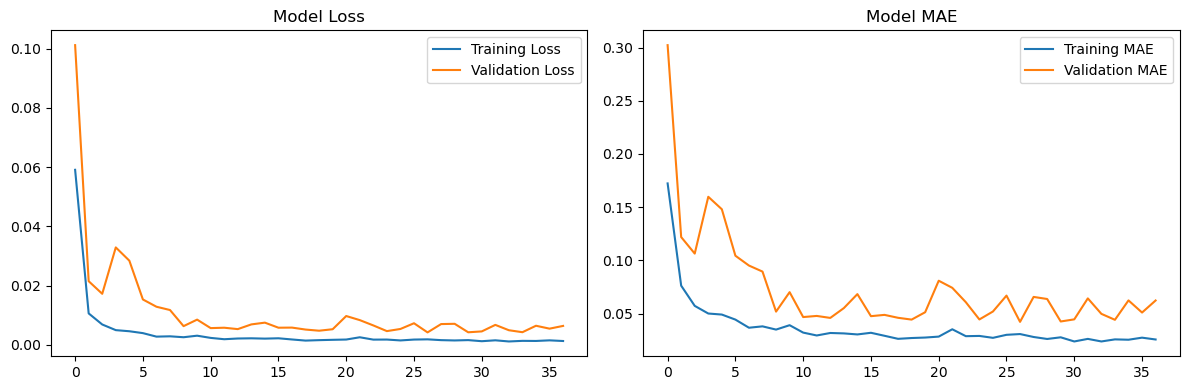

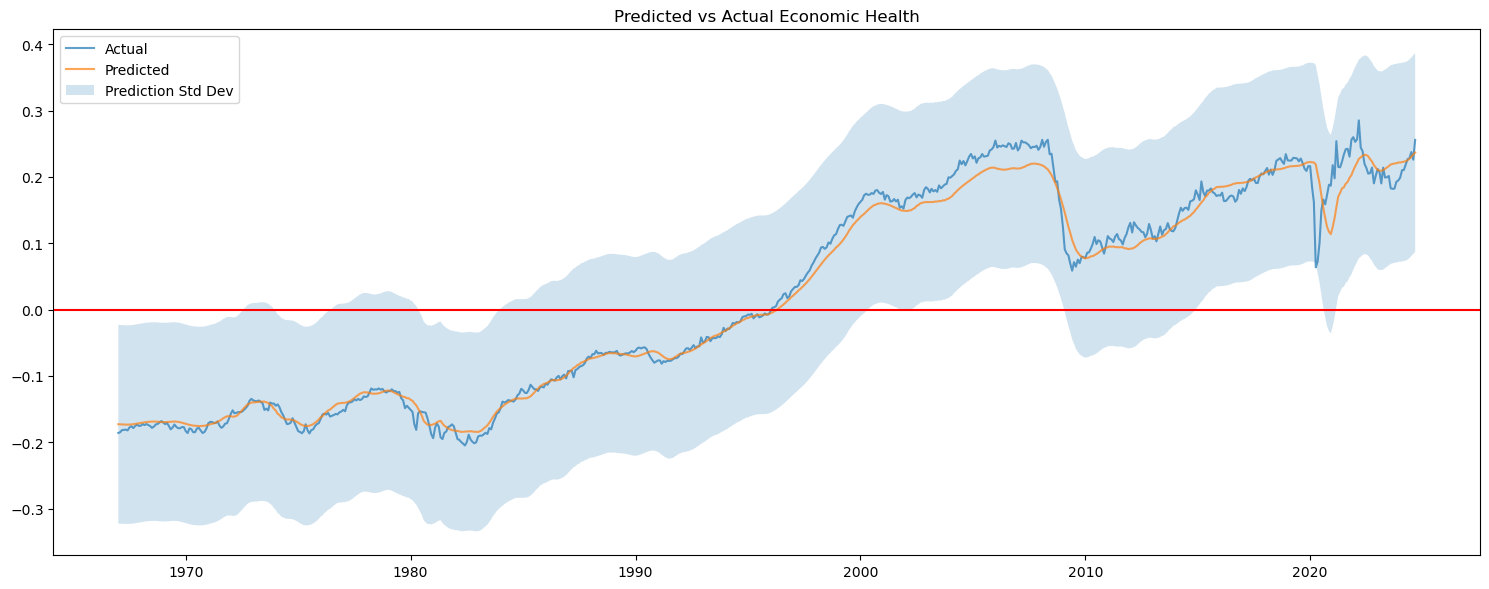

In [44]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# Клас за предсказване на икономическо здраве
class EconomicHealthPredictor:
    def __init__(self, lookback=12):
        self.lookback = lookback
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        self.model = None

    def create_composite_health_score(self, data):
        """
        Creates a composite index of economic health with updated indicators.
        
        Positive indicators (Sum = 1): 
        - GDP (core economic growth indicator)
        - INDPRO (industrial production)
        - SP500 (market stability)
        - PAYEMS (employment)
        - GDP_PCA (population welfare)
        - PASAVERT (population savings)

        Negative indicators (Sum = -1):
        - DEBT (total public debt)
        - CPI (inflation)
        - UNEMPLOYMENT (unemployment)
        - FEDFUNDS (cost of borrowing)
        - DEBT_PER_GDP (debt burden)
        - TB (trade deficit)
        - ENERGY (energy costs)
        """
        weights = {
            'gdp': 0.2,            # A key indicator of economic health.
            'indpro': 0.2,         # Production capacity indicator.
            'sp500': 0.1,          # Market confidence indicator.
            'payems': 0.2,         # An important indicator of employment.
            'gdp_pca': 0.2,        # Standard of living indicator.
            'pasavert': 0.1,       # Household financial stability indicator.
            'debt': -0.3,          # The main problem facing the economy.
            'cpi': -0.2,           # Negative impact of inflation.
            'unrate': -0.1,        # Main negative social indicator.
            'fedfunds': -0.1,      # Impact on the price of loans.
            'debt_per_gdp': -0.05, # Long-term financial stability.
            'tb': -0.2,            # Foreign trade balance.
            'energy': -0.05        # Energy dependence.
       }
        normalized_data = self.scaler_X.fit_transform(data)
        df_normalized = pd.DataFrame(normalized_data, columns=data.columns)

        health_score = sum(
            df_normalized[col] * weight for col, weight in weights.items() if col in df_normalized.columns
        )
        return health_score

    def prepare_sequences(self, X, y):
        X_seq, y_seq = [], []
        for i in range(len(X) - self.lookback):
            X_seq.append(X[i:(i + self.lookback)])
            y_seq.append(y[i + self.lookback])
        return np.array(X_seq), np.array(y_seq)

    def build_model(self, input_shape):
        """
        Creates a model.
        """
        model = Sequential([
            Conv1D(128, kernel_size=5, activation='relu', input_shape=input_shape),
            MaxPooling1D(pool_size=2),
            LSTM(256, return_sequences=True),
            Dropout(0.3),
            LSTM(128, return_sequences=False),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def fit(self, X, epochs=100, validation_split=0.2, verbose=0):
        y = self.create_composite_health_score(X)
        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.values.reshape(-1, 1))

        X_seq, y_seq = self.prepare_sequences(X_scaled, y_scaled)
        self.model = self.build_model((self.lookback, X.shape[1]))

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = self.model.fit(
            X_seq, y_seq,
            epochs=epochs,
            validation_split=validation_split,
            callbacks=[early_stopping],
            verbose=verbose
        )

        return history

    def predict(self, X):
        X_scaled = self.scaler_X.transform(X)
        X_seq, _ = self.prepare_sequences(X_scaled, np.zeros(len(X_scaled)))
        predictions = self.model.predict(X_seq, verbose=0)
        return self.scaler_y.inverse_transform(predictions)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    # The error between predicted and actual values.
    plt.title('Model Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    # The average absolute difference between predicted and actual values.
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_predictions(true_values, predictions, dates):
    true_values = np.array(true_values).flatten()
    predictions = np.array(predictions).flatten()

    plt.figure(figsize=(15, 6))
    plt.plot(dates, true_values, label='Actual', alpha=0.7)
    plt.plot(dates, predictions, label='Predicted', alpha=0.7)

    std_dev = predictions.std()
    plt.fill_between(
        dates,
        predictions - std_dev,
        predictions + std_dev,
        alpha=0.2,
        label='Prediction Std Dev'
    )

    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.title('Predicted vs Actual Economic Health')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Главна функция за анализ
def run_analysis(data):
    print("Training the model...")
    predictor = EconomicHealthPredictor(lookback=12)
    history = predictor.fit(data, epochs=50, validation_split=0.2, verbose=1)

    # Визуализация на процеса на обучение
    plot_training_history(history)

    # Правене на предикции
    predictions = predictor.predict(data)
    health_score = predictor.create_composite_health_score(data)

    # Визуализация на предикциите
    plot_predictions(health_score[12:], predictions, data.index[12:])

    return predictor

# Изпълнение на анализа с примерни данни
if __name__ == "__main__":
    # Ако зареждаме данни от файл.
    # data = pd.read_csv("data/data.csv", index_col=0, parse_dates=True)
    predictor = run_analysis(data)

TO DO: **Model Loss = ? Model MAE = ?**

### 4. **Debt forecasting**

**Input**: GDP, FEDFUNDS, UNRATE, PCEPI, GFDEBTN, XAU<br>
**Target**: Total Public Debt as Percent of Gross Domestic Product (GFDEGDQ188S) - after 12 months<br>
**Model**: Transformer architecture<br>
**Objective**: To predict when debt will reach 175% of GDP

### 5. **Conclusions**

### Resources:
1. **Sustainable Economic Indicators**: https://www.sustainable-environment.org.uk/Indicators/Economy.php
2. **...**: ....
3. **...**: ....
4. **...**: ....
5. **...**: ....
6. **...**: ....
7. **...**: ....
8. **...**: ....
9. **...**: ....
10. **...**: ....
11. **...**: ....
12. **...**: ....
13. **...**: ....
14. **...**: ....
15. **...**: ....